#**Mall Customers Segmentation**

https://www.kaggle.com/code/datark1/customers-clustering-k-means-dbscan-and-ap/notebook

* This project shows how to perform a mall customers segmentation using Machine Learning algorithms.

* KMeans, Affinity Propagation, DBSCAN

##**1.Introduction**
* Clustering is unsupervised machine learning
* Hierarchical algorithms
  * recursively split a dataset into a smaller subset until a subset contains only one item.
  * Dendrogram
* Partitional algorithms
  * Dived a dataset into several subsets based on a given criteria.
  * For some algorithms number of clusters has to be defined a priori(KMeans) and for some not(DBSCAN)
  * Defining the number of clusters before running and algorithm often requires a specific domain knowledge

##**2.Reading Data**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("seaborn version: {}".format(sns.__version__))

pandas version: 1.3.5
numpy version: 1.21.6
seaborn version: 0.11.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
mall_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/OB/DataSet/Mall_Customers.csv')

print('There are {} rows and {} columns in our dataset.'.format(mall_data.shape[0],mall_data.shape[1]))

There are 200 rows and 5 columns in our dataset.


In [4]:
mall_data.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
94,95,Female,32,60,42
43,44,Female,31,39,61
149,150,Male,34,78,90
36,37,Female,42,34,17
121,122,Female,38,67,40
99,100,Male,20,61,49
92,93,Male,48,60,49
131,132,Male,39,71,75
59,60,Male,53,46,46
68,69,Male,19,48,59


In [5]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


* 5 columns
  * CustomerID - numerical
  * Gender - categorical
  * Age - numerical
  * Annumal Income - numerical
  * Spending Score - numerical

* In clustering, one-hot encoding is
  * technically possible
  * theoretically not forbidden
  * practically not recommended


In [6]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [7]:
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

* no missing data

##**3.Exploratory Data Analysis**

###1) Distributions

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


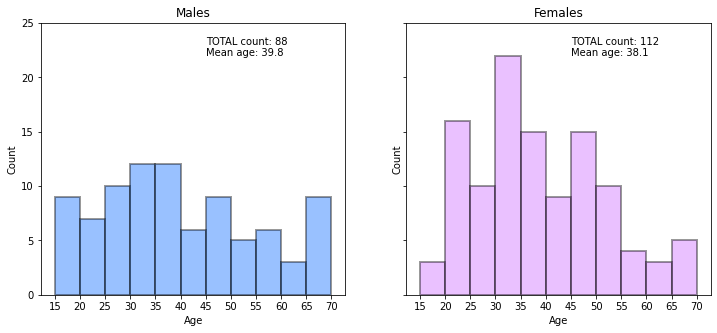

In [8]:
# subset with males age
males_age = mall_data[mall_data['Gender']=='Male']['Age'] 
# subset with females age
females_age = mall_data[mall_data['Gender']=='Female']['Age'] 

age_bins = range(15,75,5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

In [9]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_age, females_age)[1]))

Kolgomorov-Smirnov test p-value: 0.49


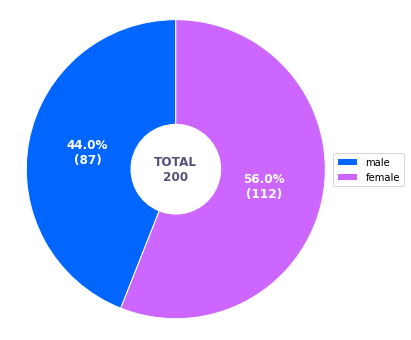

In [10]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,colors=['#0066ff','#cc66ff'],startangle=90,
                                   textprops=dict(color="w"),wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],loc='center right',bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(mall_data['Age'].count()),weight='bold', size=12, color='#52527a',ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


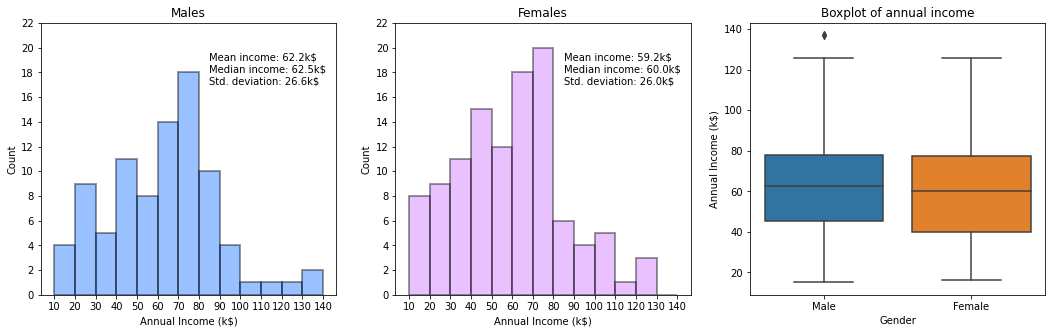

In [11]:
males_income = mall_data[mall_data['Gender']=='Male']['Annual Income (k$)'] # subset with males income
females_income = mall_data[mall_data['Gender']=='Female']['Annual Income (k$)'] # subset with females income

my_bins = range(10,150,10)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19, "Mean income: {:.1f}k$".format(males_income.mean()))
ax1.text(85,18, "Median income: {:.1f}k$".format(males_income.median()))
ax1.text(85,17, "Std. deviation: {:.1f}k$".format(males_income.std()))

# females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19, "Mean income: {:.1f}k$".format(females_income.mean()))
ax2.text(85,18, "Median income: {:.1f}k$".format(females_income.median()))
ax2.text(85,17, "Std. deviation: {:.1f}k$".format(females_income.std()))

# boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()

In [12]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income, females_income)[1]))

Kolgomorov-Smirnov test p-value: 0.78


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


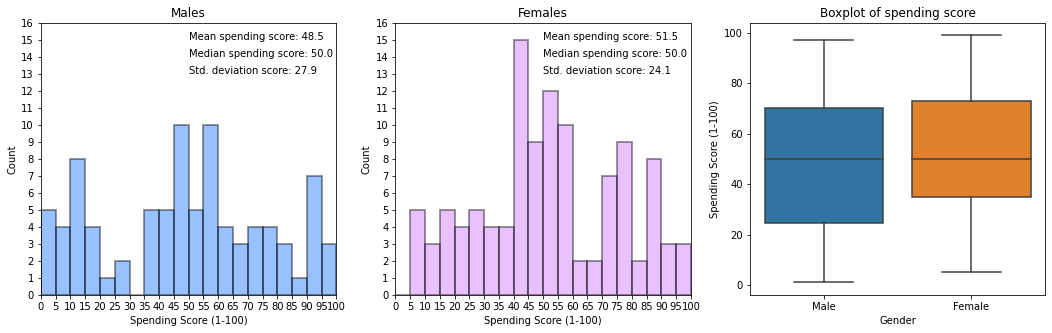

In [13]:
males_spending = mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0,105,5)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, "Mean spending score: {:.1f}".format(males_spending.mean()))
ax1.text(50,14, "Median spending score: {:.1f}".format(males_spending.median()))
ax1.text(50,13, "Std. deviation score: {:.1f}".format(males_spending.std()))

# females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0,100)
ax2.set_yticks(range(0,17,1))
ax2.set_ylim(0,16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, "Mean spending score: {:.1f}".format(females_spending.mean()))
ax2.text(50,14, "Median spending score: {:.1f}".format(females_spending.median()))
ax2.text(50,13, "Std. deviation score: {:.1f}".format(females_spending.std()))

# boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

plt.show()

In [14]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_spending, females_spending)[1]))

Kolgomorov-Smirnov test p-value: 0.29


> average age of male customers is lightly higher than female ones

> biggest age group of female is 30-35 years old

> more females (slightly)

> mean&median income of males is higher than females

> mean spending score for women is higher than men

* median incomes by age&gender

In [15]:
medians_by_age_group = mall_data.groupby(["Gender",pd.cut(mall_data['Age'], age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace=True)

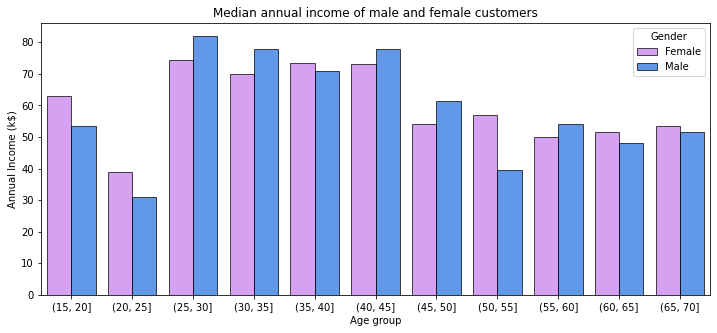

In [16]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group,palette=['#cc66ff','#0066ff'],alpha=0.7,edgecolor='k',ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

> shows that the most wealthy customers are in age of 25-45 years old

> biggest difference between women and men is visible in age groups 25-30 and 50-55

###2) Correlations

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


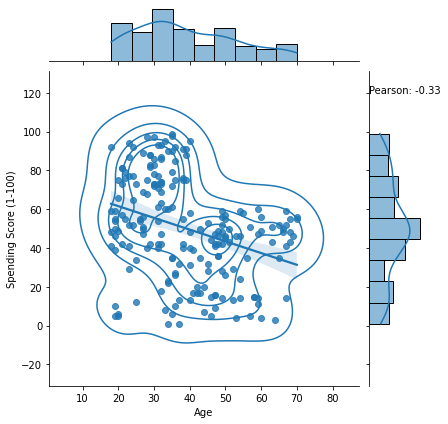

In [17]:
from scipy.stats import pearsonr

# calculating Pearson's correlation
corr, _ = pearsonr(mall_data['Age'], mall_data['Spending Score (1-100)'])
jp = (sns.jointplot('Age', 'Spending Score (1-100)', data=mall_data, kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.text(0,120, 'Pearson: {:.2f}'.format(corr))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


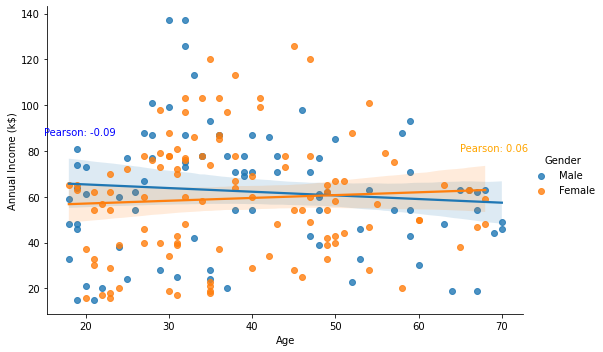

In [18]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot('Age', 'Annual Income (k$)', data=mall_data, hue='Gender', aspect=1.5)

plt.text(15,87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65,80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


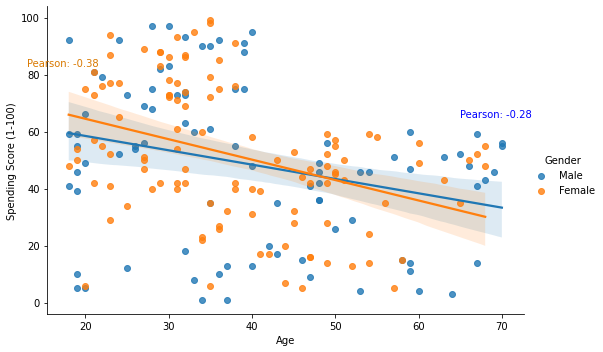

In [19]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)

sns.lmplot('Age', 'Spending Score (1-100)', data=mall_data, hue='Gender',aspect=1.5)

plt.text(65,65, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(13,83, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


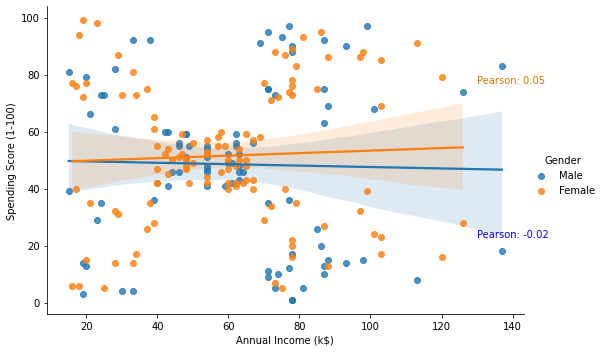

In [20]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot('Annual Income (k$)', 'Spending Score (1-100)', data=mall_data, hue='Gender',aspect=1.5)

plt.text(130,23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130,77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

> negligible correlation between age and annual income of cutomers for both sex groups

> week negative correlations between age and spending score for both sex groups

> negligible correlation between annual income and spending score of customers for both sex groups

##**4.Clustering**

* K-Means
* Density-Based Spatial Clustering of Applications with Noise (DBSCAN)
* Affinity Propagation

###1) K-Means

####(1) Description

1. Split samples into initial groups by using seed points. The nearest samples to these seed point will create initial clusters.

2. Calculate samples distances to groups' central pooints(centroids) and assign the nearest samples to their cluster.

3. The third step is to calculate newly created (updated) cluster centroids

4. Repeat steps 2 and 3 until the algorithm converges.


* Parameters
  * Initilaisation criteria
  * Number of clusters
  * Distance metric (not required in scikit learn implementation)


####(2) Use case - customers segmentation

In [21]:
from sklearn.cluster import KMeans 

* for clustering only numeric columns are used

In [22]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # subset with numeric variables only

* numbers of cluster

* elbow method

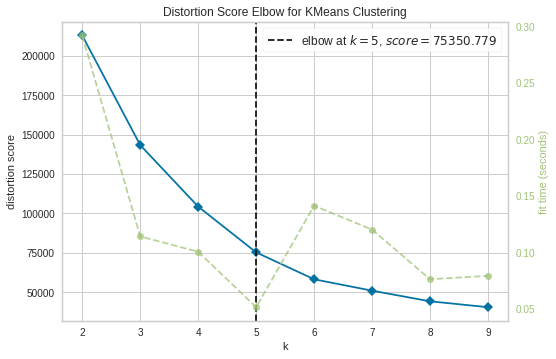

In [24]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

> 5 or 6 clusters are fair

* Silhuette score 

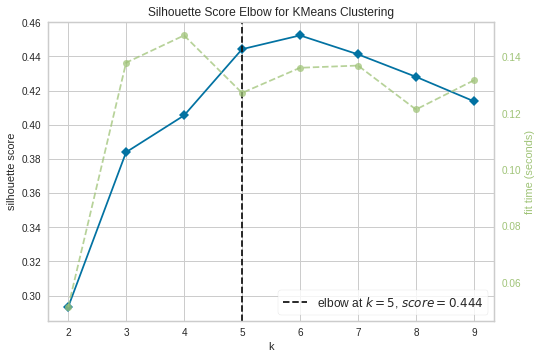

In [25]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

> 5 or 6 would be fair

* 5 clusters

In [26]:
# initialise and fit K-Means model
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics) 

KM5_clustered = X_numerics.copy()
# append labels to points
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


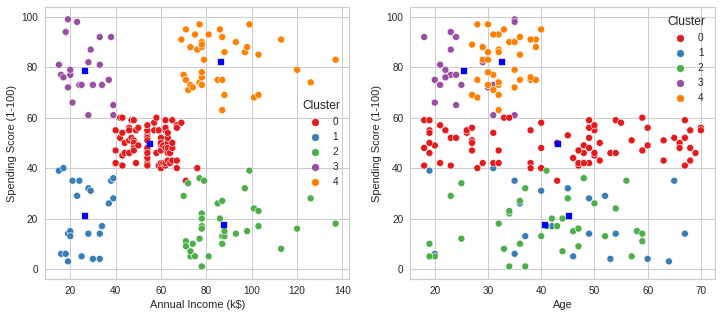

In [27]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM5_clustered, hue='Cluster', ax=axes[0], palette='Set1', legend='full')
sns.scatterplot('Age', 'Spending Score (1-100)', data=KM5_clustered, hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

> annual incom : low / spending score : high

> annual incom : medium / spending score : medium

> annual incom : high / spending score : low

> annual incom : high / spending score : high

> annual incom : low / spending score : low

In [28]:
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,79
1,23
2,36
3,23
4,39


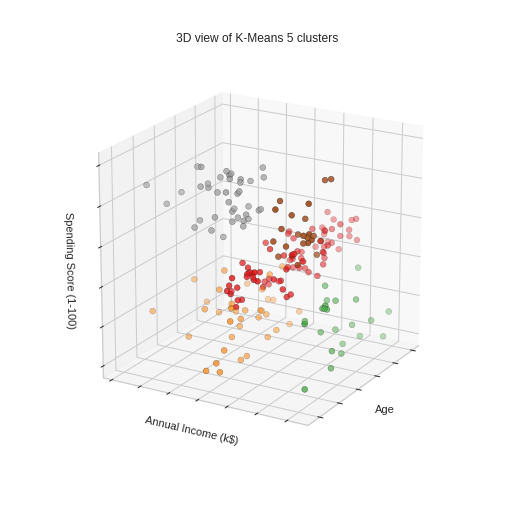

In [29]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(KM5_clustered['Age'],KM5_clustered['Annual Income (k$)'],KM5_clustered['Spending Score (1-100)'],c=KM5_clustered['Cluster'],s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()

In [30]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(x = db[db['Cluster']==n]['Age'],y = db[db['Cluster']==n]['Spending Score (1-100)'],z = db[db['Cluster']==n]['Annual Income (k$)'],
        mode = 'markers',name = name,marker = dict(size = 5))

trace0 = tracer(KM5_clustered, 0, 'Cluster 0')
trace1 = tracer(KM5_clustered, 1, 'Cluster 1')
trace2 = tracer(KM5_clustered, 2, 'Cluster 2')
trace3 = tracer(KM5_clustered, 3, 'Cluster 3')
trace4 = tracer(KM5_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(xaxis = dict(title = 'Age'),yaxis = dict(title = 'Spending Score'),zaxis = dict(title = 'Annual Income'))
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

* silhuette plot

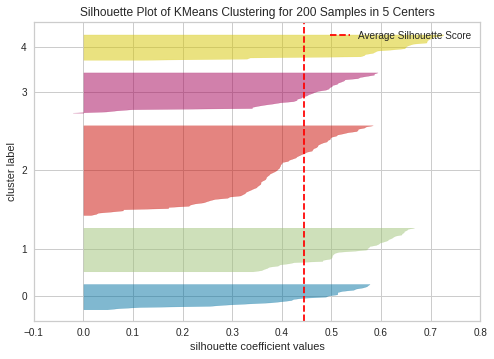

In [31]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=5, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

* 6 Clusters

In [32]:
# initialise and fit K-Means model
KM_6_clusters = KMeans(n_clusters=6, init='k-means++').fit(X_numerics) 

# append labels to points
KM6_clustered = X_numerics.copy()
KM6_clustered.loc[:,'Cluster'] = KM_6_clusters.labels_ 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



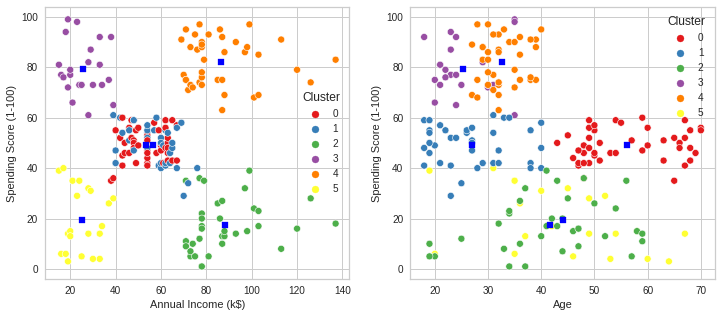

In [33]:
fig11, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM6_clustered,hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=KM6_clustered,hue='Cluster', palette='Set1', ax=axes[1], legend='full')

# plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:,1], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_6_clusters.cluster_centers_[:,0], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

> younger / annual : medium / spending score : medium

> annual : high / spending score : low

> younger / annual : medium / spending score : medium

> annual : high / spending score : high

> annual : low / spending score : low

> annual : low / spending score : high


In [34]:
KM6_clust_sizes = KM6_clustered.groupby('Cluster').size().to_frame()
KM6_clust_sizes.columns = ["KM_size"]
KM6_clust_sizes

,KM_size
Cluster,
0,45
1,38
2,35
3,22
4,39
5,21


In [35]:
trace0 = tracer(KM6_clustered, 0, 'Cluster 0')
trace1 = tracer(KM6_clustered, 1, 'Cluster 1')
trace2 = tracer(KM6_clustered, 2, 'Cluster 2')
trace3 = tracer(KM6_clustered, 3, 'Cluster 3')
trace4 = tracer(KM6_clustered, 4, 'Cluster 4')
trace5 = tracer(KM6_clustered, 5, 'Cluster 5')

data = [trace0, trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(title = 'Clusters by K-Means',
    scene = dict(xaxis = dict(title = 'Age'),yaxis = dict(title = 'Spending Score'),zaxis = dict(title = 'Annual Income')))

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

* silhouette score

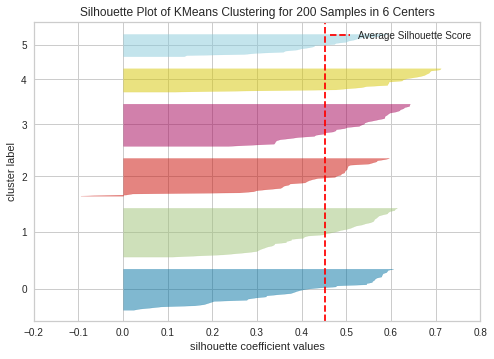

In [36]:
model = KMeans(n_clusters=6, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

###2) DBSCAN
Density-Based Spatial Clustering of Applications with Noise

####(1) Description

* Eps - distance
* MinPts - Minimum number of points within distance Eps

* Dense region is therefore created by a minimum number of points within distance between all of the, Eps.

* Border points : wwithing the distance but not close to minimum number of other ponts are treated

* Outliers : Remaining ones

* Advantages
  * it finds number of clusters itself, based on eps and MinPts parameters
  * It is able to differentiate elongated clusters or clusters surrounded by other clusters in contrary to e.g. K-Means where clusters are always convex.
  * It is also able to find points not fitting into any cluster - it detects outliers

* Drawback
  * High computational expense of average O(nlogn) coming from a need to execute a neighbourhood query for each point.
  * Poorly identifies clusters with various densities.

####(2) Use case - customers segmentation 

In [37]:
from sklearn.cluster import DBSCAN

* hyper parameters
  * Eps
  * min_samples

In [38]:
from itertools import product

# eps values to be investigated
eps_values = np.arange(8,12.75,0.25) 
# min_samples values to be investigated
min_samples = np.arange(3,10) 

DBSCAN_params = list(product(eps_values, min_samples))

In [39]:
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

* heatmap (find # of cluster)

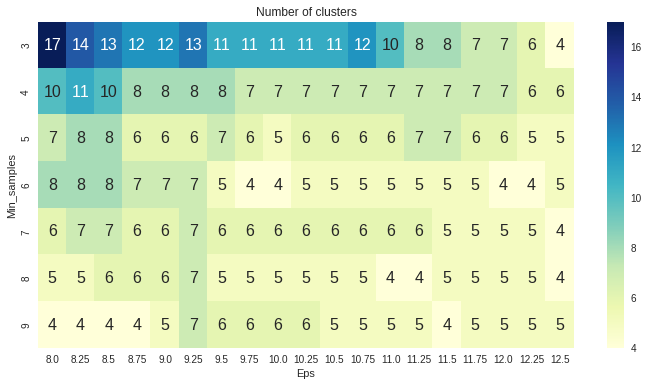

In [40]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

> 4-7 clusters

* silhouette score heatmap

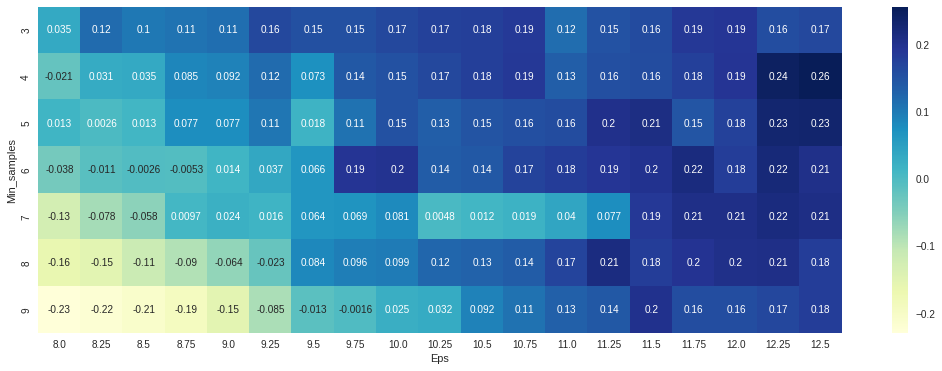

In [41]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

> eps=1.5 / min_samples=4

In [42]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_

In [43]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



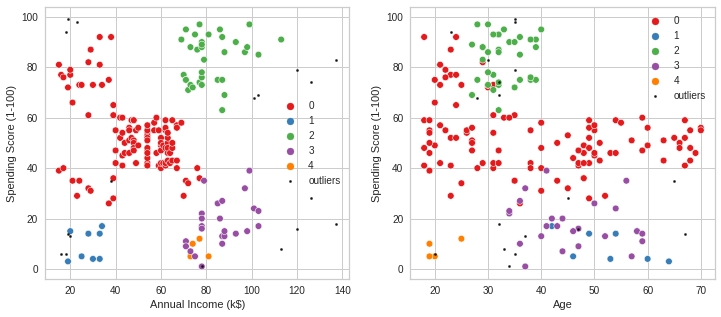

In [44]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)',data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot('Age', 'Spending Score (1-100)',data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

> There are some outliers- these points do not meet distance and minimum samples requirements to be recognised as a cluster

###3) Affinity Propagation 

####(1) Description

* It is built around the concept of sending messages between a pair of points until it converges. These messages are a way of measuring how similar these two pints are to each other and can they be exemplars of each other.

* Find the number of clusters itself

* O(n^2T) - T:number of iterations

* lack of sensitivity to the initialisation criteria

* Parameters
  * preference which is a negative number and controls how many exemplars are used
  * Damping factor which prevents numerical oscillations when updating messages

  

####(2) Use case - customers segmentation

In [54]:
from sklearn.cluster import AffinityPropagation

In [55]:
no_of_clusters = []
preferences = range(-20000,-5000,200) # arbitraty chosen range
af_sil_score = [] # silouette scores

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X_numerics)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X_numerics, AF.labels_))
    
af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head() # display only 5 best scores

,preference,clusters,sil_score
41,-11800.0,6.0,0.451649
63,-7400.0,6.0,0.451440
26,-14800.0,6.0,0.451440
46,-10800.0,6.0,0.451440
14,-17200.0,6.0,0.451440


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



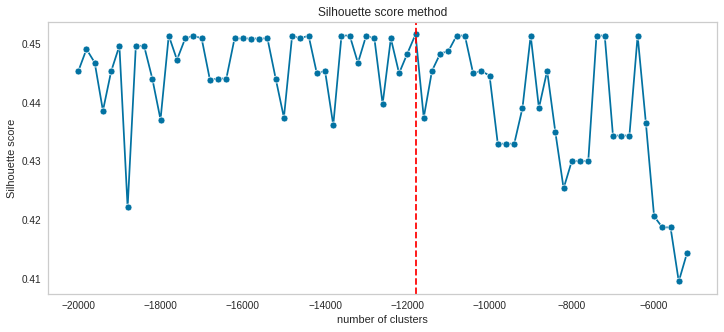

In [56]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(preferences, af_sil_score, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(-11800, ls="--", c="red")
plt.grid()
plt.show()

In [57]:
AF=AffinityPropagation(preference=-11800).fit(X_numerics)

In [58]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_

In [59]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



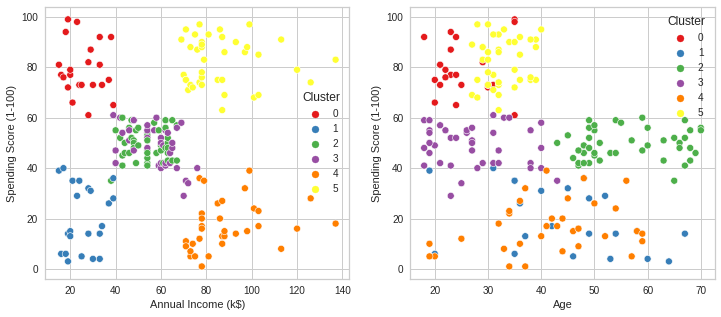

In [60]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))
scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=AF_clustered,hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')
sns.scatterplot('Age', 'Spending Score (1-100)', data=AF_clustered,hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

##**5.Comparision and discussion**

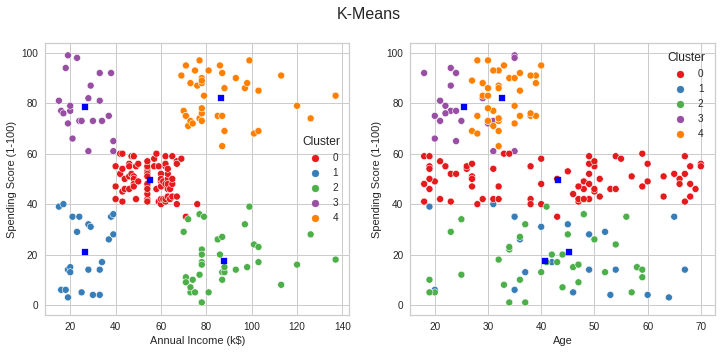

In [49]:
fig1.suptitle('K-Means', fontsize=16)
fig1

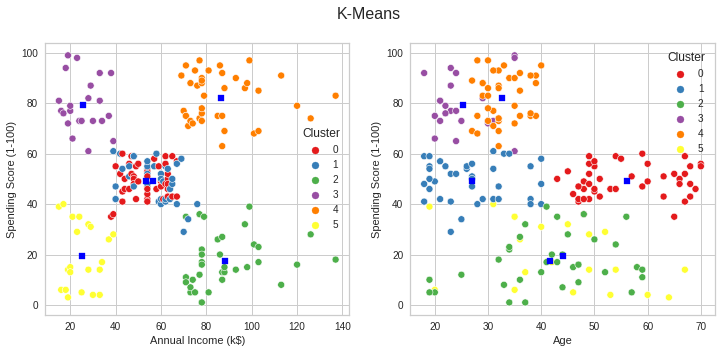

In [50]:
fig11.suptitle('K-Means', fontsize=16)
fig11

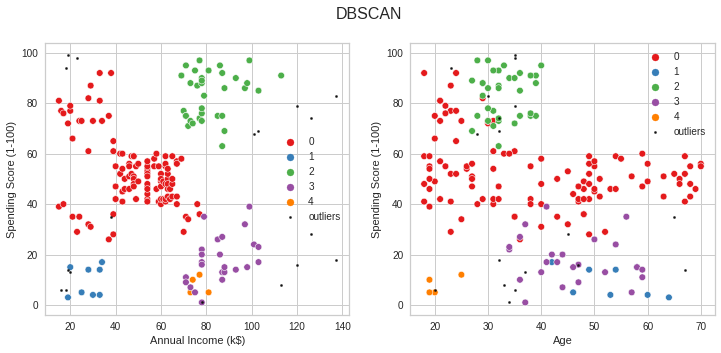

In [51]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

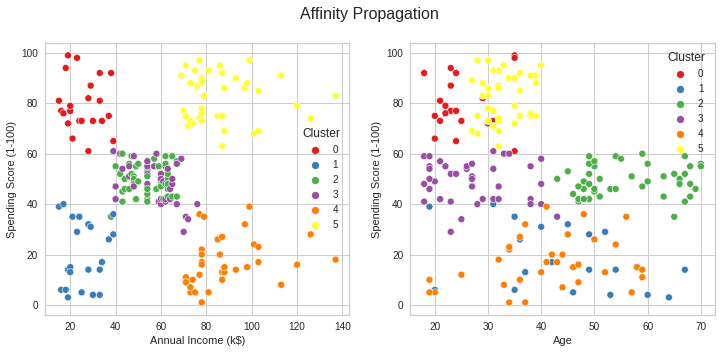

In [61]:
fig3.suptitle('Affinity Propagation', fontsize=16)
fig3

In [62]:
clusters = pd.concat([KM6_clust_sizes, DBSCAN_clust_sizes, AF_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size,AF_size
Cluster,,,
-1,NaN,18.0,NaN
0,45.0,112.0,22.0
1,38.0,8.0,22.0
2,35.0,34.0,44.0
3,22.0,24.0,39.0
4,39.0,4.0,34.0
5,21.0,NaN,39.0


> DBSCAN failed to generate reasonable clusters. It is most likely because DBSCAN tries to find clusters based on the density of points. If one of our clusters is less dense than others DBSCAN will produce suboptimal results by not recognising the least dense group as a cluster.

> K-Means and Affinity propagatio created reasonable 6 clusters.